In [136]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
pd.set_option('display.max_rows', None)   # show all rows
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000
pd.set_option('display.width', 1000)

## Data Cleaning

In [137]:
df = pd.read_csv('italy-house-prices/rome_rents_raw.csv', encoding='latin-1')
df.columns = [col.lower().strip() for col in df.columns]
df.columns

Index(['prezzo', 'stanze', 'm2', 'bagni', 'piano', 'description', 'riferimento e data annuncio', 'contratto', 'tipologia', 'superficie', 'locali', 'totale piani edificio', 'posti auto', 'disponibilità', 'other_characteristics', 'citta', 'quartiere', 'href', 'via', 'unità', 'data di inizio lavori e di consegna prevista', 'uso edificio attuale', 'dati catastali', 'altri dati catastali', 'altre caratteristiche', 'spese condominio', 'cauzione', 'anno di costruzione', 'stato', 'riscaldamento', 'climatizzatore', 'efficienza energetica', 'indice prest. energetica rinnovabile', 'prestazione energetica del fabbricato', 'certificazione energetica', 'emissioni di co?', 'spese aggiuntive', 'regione'], dtype='object')

In [138]:
cleaned_df = pd.read_csv('italy-house-prices/rome_rents_clean_our_version.csv')
cleaned_df.columns = [col.lower().strip() for col in cleaned_df.columns]
display(cleaned_df.columns)
display(cleaned_df.dtypes)

Index(['price', 'condo_fees', 'm2', 'rooms', 'more_than_5_rooms', 'floor', 'lift', 'disabled_access', 'raised_floor', 'multi_floor', 'total_floors_building', 'last_floor', 'rent', 'free_rent', 'rent_min_duration', 'rent_renewal_duration', 'controlled_rent', 'short_term_rent', 'student_rent', 'buyout_rent', 'income_property', 'room_total', 'bedrooms', 'other_rooms', 'kitchen_type', 'tennis_court', 'bathrooms', 'more_than_3_bathrooms', 'bathrooms_per_room', 'garage_box', 'outdoor_parking', 'common_parking', 'private_box', 'has_garage_box', 'has_outdoor_parking', 'has_common_parking', 'has_private_box', 'stato_condition', 'stato_renovation', 'condominium', 'penthouse', 'single_family_villa', 'semi_detached_villa', 'multi_family_villa', 'open_space', 'attic', 'loft', 'building', 'farmhouse', 'terraced_house_single', 'terraced_house_multi', 'prestigious_class', 'middle_class', 'economical_class', 'luxury_property', 'full_ownership', 'partial_ownership', 'right_of_surface',
       'bare_owne

price                                float64
condo_fees                           float64
m2                                   float64
rooms                                float64
more_than_5_rooms                     object
floor                                float64
lift                                    bool
disabled_access                         bool
raised_floor                            bool
multi_floor                             bool
total_floors_building                float64
last_floor                              bool
rent                                    bool
free_rent                               bool
rent_min_duration                      int64
rent_renewal_duration                  int64
controlled_rent                         bool
short_term_rent                         bool
student_rent                            bool
buyout_rent                             bool
income_property                         bool
room_total                             int64
bedrooms  

In [139]:
# remove rows with missing target
cleaned_df = cleaned_df[cleaned_df['price'].notna()]
display(cleaned_df.shape)

(13188, 130)

In [140]:
# convert all values to numeric, categorical and boolean as appropriate
# save in three arrays of column names
numeric_cols = []
categorical_cols = []
boolean_cols = []
onehot_candidates = ['kitchen_type', 'energy_efficiency_class', 'neighborhood', 'stato_condition', 'stato_renovation', 'municipality', 'zone']
onehot_cols = [col for col in onehot_candidates if col in cleaned_df.columns]

numerical_df = pd.DataFrame()
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == 'object':
        try:
            numerical_df[col] = pd.to_numeric(cleaned_df[col])
            numeric_cols.append(col)
        except ValueError:
            # if fails, convert to categorical
            if col in onehot_cols:
                # skip one-hot columns for now
                continue
            numerical_df[col] = cleaned_df[col].astype('category')
            categorical_cols.append(col)
    elif cleaned_df[col].dtype == 'bool':
        numerical_df[col] = cleaned_df[col].astype('boolean')
        boolean_cols.append(col)

display(numerical_df.dtypes)

more_than_5_rooms               float64
lift                            boolean
disabled_access                 boolean
raised_floor                    boolean
multi_floor                     boolean
last_floor                      boolean
rent                            boolean
free_rent                       boolean
controlled_rent                 boolean
short_term_rent                 boolean
student_rent                    boolean
buyout_rent                     boolean
income_property                 boolean
tennis_court                    boolean
more_than_3_bathrooms           boolean
has_garage_box                  boolean
has_outdoor_parking             boolean
has_common_parking              boolean
has_private_box                 boolean
condominium                     boolean
penthouse                       boolean
single_family_villa             boolean
semi_detached_villa             boolean
multi_family_villa              boolean
open_space                      boolean


In [141]:
# convert categorical columns to label encoding
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in numerical_df.select_dtypes(include=['category']).columns:
    le = LabelEncoder()
    numerical_df[col] = le.fit_transform(numerical_df[col])
    label_encoders[col] = le

In [142]:
# show columns with high correlation
# exclude self-correlation and duplicate pairs by using the upper triangle of the correlation matrix
threshold = 0.90  # adjust as needed (absolute correlation)
# compute correlation on numeric columns only
corr = numerical_df.select_dtypes(include=[
    'number'
]).corr()
# mask to keep upper triangle without diagonal (k=1) -> no self-pairs and no duplicate pairs
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
# apply mask and stack to long format
upper_corr = corr.where(mask)
high_correlation = upper_corr.stack().reset_index()
high_correlation.columns = ['Feature 1', 'Feature 2', 'Correlation']
# filter by absolute correlation threshold and sort by absolute value descending
high_correlation = high_correlation[high_correlation['Correlation'].abs() > threshold].copy()
high_correlation = high_correlation.reindex(high_correlation['Correlation'].abs().sort_values(ascending=False).index)
# display results
display(high_correlation)

,Feature 1,Feature 2,Correlation


In [143]:
# remove one of each pair of highly correlated features
# policy: always keep 'price' if present in a correlated pair; otherwise remove the second feature (Feature 2) deterministically
to_remove = set()
for _, row in high_correlation.iterrows():
    # use absolute correlation and the same threshold used above
    try:
        th = threshold
    except NameError:
        th = 0.90
    if abs(row['Correlation']) > th:
        f1 = row['Feature 1']
        f2 = row['Feature 2']
        # prefer keeping 'price' column
        if f1 == 'price':
            to_remove.add(f2)
        elif f2 == 'price':
            to_remove.add(f1)
        else:
            # deterministically remove Feature 2 to avoid ambiguity
            to_remove.add(f2)

display(to_remove)
# Drop only columns that exist in the dataframe
for col in sorted(to_remove):
    if col in cleaned_df.columns:
        cleaned_df = cleaned_df.drop(columns=[col])
    else:
        print(f"Column {col} not found in cleaned_df columns, skipping")

display(cleaned_df.columns)

set()

Index(['price', 'condo_fees', 'm2', 'rooms', 'more_than_5_rooms', 'floor', 'lift', 'disabled_access', 'raised_floor', 'multi_floor', 'total_floors_building', 'last_floor', 'rent', 'free_rent', 'rent_min_duration', 'rent_renewal_duration', 'controlled_rent', 'short_term_rent', 'student_rent', 'buyout_rent', 'income_property', 'room_total', 'bedrooms', 'other_rooms', 'kitchen_type', 'tennis_court', 'bathrooms', 'more_than_3_bathrooms', 'bathrooms_per_room', 'garage_box', 'outdoor_parking', 'common_parking', 'private_box', 'has_garage_box', 'has_outdoor_parking', 'has_common_parking', 'has_private_box', 'stato_condition', 'stato_renovation', 'condominium', 'penthouse', 'single_family_villa', 'semi_detached_villa', 'multi_family_villa', 'open_space', 'attic', 'loft', 'building', 'farmhouse', 'terraced_house_single', 'terraced_house_multi', 'prestigious_class', 'middle_class', 'economical_class', 'luxury_property', 'full_ownership', 'partial_ownership', 'right_of_surface',
       'bare_owne

In [144]:
# One-hot encode selected categorical features that are appropriate to expand
# Create boolean dummy columns named using a readable display of the original column name
onehot_cols = [c for c in onehot_candidates if c in cleaned_df.columns]
print('One-hot candidates found:', onehot_cols)

cleaned_df = pd.get_dummies(cleaned_df, columns=onehot_cols, drop_first=True, dtype='boolean')
display(cleaned_df.shape)

One-hot candidates found: ['kitchen_type', 'energy_efficiency_class', 'neighborhood', 'stato_condition', 'stato_renovation', 'municipality', 'zone']


(13188, 398)

In [145]:
display(cleaned_df.columns)

Index(['price', 'condo_fees', 'm2', 'rooms', 'more_than_5_rooms', 'floor', 'lift', 'disabled_access', 'raised_floor', 'multi_floor', 'total_floors_building', 'last_floor', 'rent', 'free_rent', 'rent_min_duration', 'rent_renewal_duration', 'controlled_rent', 'short_term_rent', 'student_rent', 'buyout_rent', 'income_property', 'room_total', 'bedrooms', 'other_rooms', 'tennis_court', 'bathrooms', 'more_than_3_bathrooms', 'bathrooms_per_room', 'garage_box', 'outdoor_parking', 'common_parking', 'private_box', 'has_garage_box', 'has_outdoor_parking', 'has_common_parking', 'has_private_box', 'condominium', 'penthouse', 'single_family_villa', 'semi_detached_villa', 'multi_family_villa', 'open_space', 'attic', 'loft', 'building', 'farmhouse', 'terraced_house_single', 'terraced_house_multi', 'prestigious_class', 'middle_class', 'economical_class', 'luxury_property', 'full_ownership', 'partial_ownership', 'right_of_surface', 'bare_ownership', 'usufruct', 'timeshare', 'is_available',
       'const

### Missing Values Handling

In [146]:
# where missing values are > 0
missing_values = cleaned_df.isna().sum()
missing_values = missing_values[missing_values > 0]
display(missing_values)

condo_fees                            8656
m2                                     226
rooms                                  188
more_than_5_rooms                      105
floor                                  361
total_floors_building                13188
bathrooms                              383
bathrooms_per_room                     383
is_available                          2585
construction_year                     5045
energy_efficiency_consumption_kwh     1215
deposit                               5189
insidegra                              514
dtype: int64

In [147]:
# remove all values where it is the only one with that Neighborhood == True
for col in cleaned_df.columns:
    if col.startswith('neighborhood_'):
        count_true = cleaned_df[col].sum()
        if count_true == 1:
            cleaned_df = cleaned_df[cleaned_df[col] != True]

# put false to is_available when is NaN
cleaned_df['is_available'] = cleaned_df['is_available'].infer_objects(copy=False)

# remove all where insidegra is NaN
cleaned_df = cleaned_df[cleaned_df['insidegra'].notna()]
cleaned_df.shape


(12624, 398)

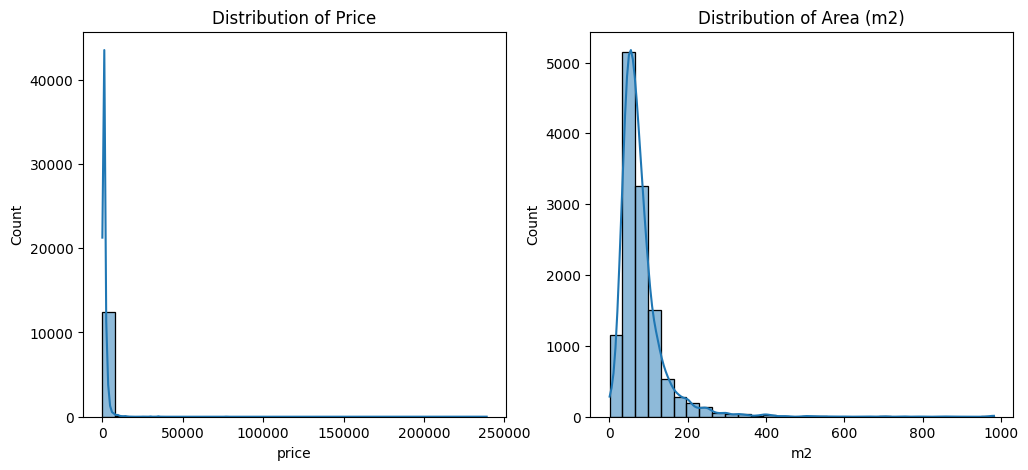

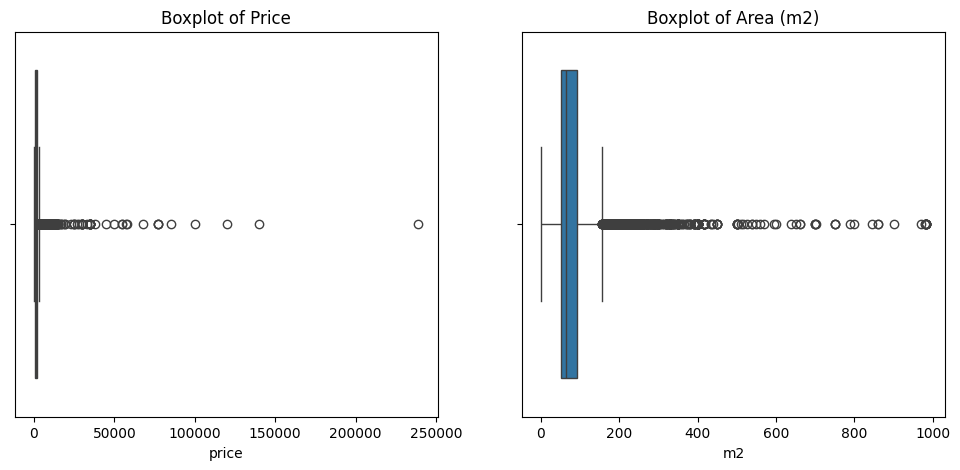

In [149]:
# plot the distribution of 'price' and 'm2' columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(cleaned_df['price'].dropna(), bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price')
sns.histplot(cleaned_df['m2'].dropna(), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Area (m2)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=cleaned_df['price'], ax=axes[0])
axes[0].set_title('Boxplot of Price')
sns.boxplot(x=cleaned_df['m2'], ax=axes[1])
axes[1].set_title('Boxplot of Area (m2)')
plt.show()

In [150]:
def handle_outliers(df, columns, lower_percentile=0.01, upper_percentile=0.99, keep_na=True):
    """
    Removes outliers from specified columns based on given percentiles.

    Parameters:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to handle outliers for.
        lower_percentile (float): Lower percentile threshold (default: 0.01).
        upper_percentile (float): Upper percentile threshold (default: 0.99).
        keep_na (bool): If True, rows with non-numeric / NaN values in the column are kept; if False they are dropped.

    Returns:
        pd.DataFrame: A dataframe with outliers removed from specified columns.
    """
    df = df.copy()
    for col in columns:
        if col not in df.columns:
            print(f"Column {col} not found in dataframe. Skipping.")
            continue

        # Coerce to numeric; non-convertible values become NaN
        numeric = pd.to_numeric(df[col], errors='coerce')
        numeric_nonnull = numeric.dropna()
        if numeric_nonnull.empty:
            print(f"Column {col} contains no numeric data after coercion. Skipping.")
            continue

        lower_bound = numeric_nonnull.quantile(lower_percentile)
        upper_bound = numeric_nonnull.quantile(upper_percentile)

        # Build mask: True for rows to keep
        within_bounds = numeric.between(lower_bound, upper_bound)
        if keep_na:
            mask = within_bounds | numeric.isna()
        else:
            mask = within_bounds

        df = df[mask]
    return df

# Example usage:
# drop extreme high prices (keep NaNs if any)
cleaned_df = handle_outliers(cleaned_df, ['price'], lower_percentile=0.01, upper_percentile=0.85)
# trim extreme m2 values (keep NaNs)
cleaned_df = handle_outliers(cleaned_df, ['m2'], lower_percentile=0.00, upper_percentile=0.95)
# how many rows were removed?
print(f"Rows after outlier removal: {cleaned_df.shape[0]}")

Rows after outlier removal: 10187


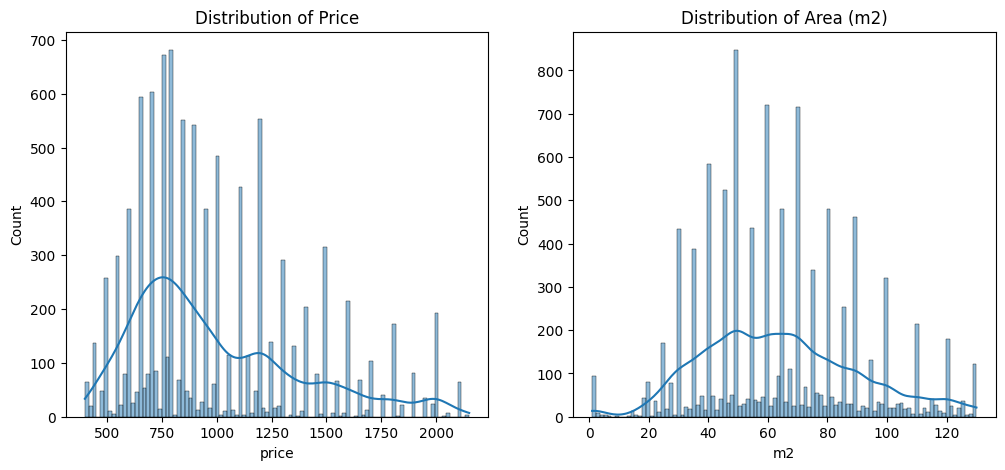

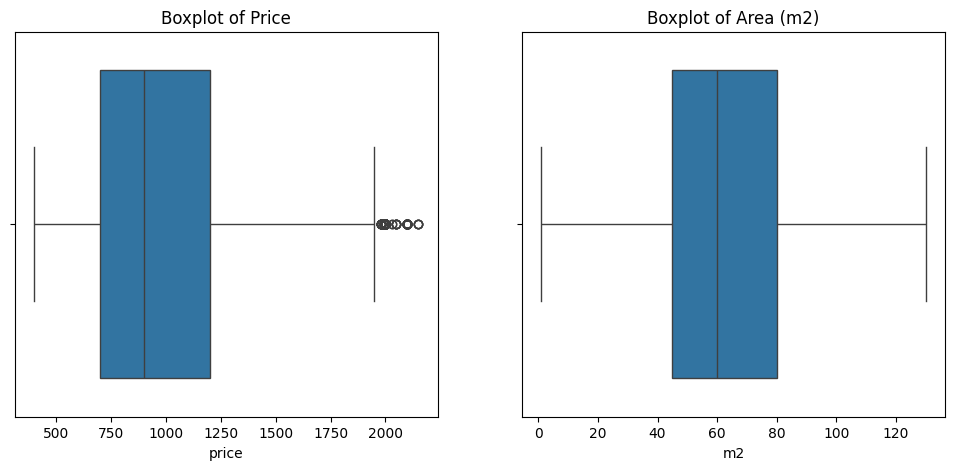

In [151]:
# plot the distribution of 'price' and 'm2' columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(cleaned_df['price'].dropna(), bins=100, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price')
sns.histplot(cleaned_df['m2'].dropna(), bins=100, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Area (m2)')
plt.show()  

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=cleaned_df['price'], ax=axes[0])
axes[0].set_title('Boxplot of Price')
sns.boxplot(x=cleaned_df['m2'], ax=axes[1])
axes[1].set_title('Boxplot of Area (m2)')
plt.show()

## Feature Engineering

In [152]:
# print all features of cleaned_df
display(cleaned_df.columns)
df = cleaned_df.copy()

Index(['price', 'condo_fees', 'm2', 'rooms', 'more_than_5_rooms', 'floor', 'lift', 'disabled_access', 'raised_floor', 'multi_floor', 'total_floors_building', 'last_floor', 'rent', 'free_rent', 'rent_min_duration', 'rent_renewal_duration', 'controlled_rent', 'short_term_rent', 'student_rent', 'buyout_rent', 'income_property', 'room_total', 'bedrooms', 'other_rooms', 'tennis_court', 'bathrooms', 'more_than_3_bathrooms', 'bathrooms_per_room', 'garage_box', 'outdoor_parking', 'common_parking', 'private_box', 'has_garage_box', 'has_outdoor_parking', 'has_common_parking', 'has_private_box', 'condominium', 'penthouse', 'single_family_villa', 'semi_detached_villa', 'multi_family_villa', 'open_space', 'attic', 'loft', 'building', 'farmhouse', 'terraced_house_single', 'terraced_house_multi', 'prestigious_class', 'middle_class', 'economical_class', 'luxury_property', 'full_ownership', 'partial_ownership', 'right_of_surface', 'bare_ownership', 'usufruct', 'timeshare', 'is_available',
       'const

In [153]:
# Price per square meter (target transformation)
df['price_per_m2'] = df['price'] / df['m2']

# Room-based ratios
df['m2_per_room'] = df['m2'] / df['rooms']

# Building age 
current_year = 2024 
df['building_age'] = current_year - df['construction_year']

# Luxury score (combine luxury indicators)
luxury_features = ['luxury_property', 'prestigious_class', 'jacuzzi', 'swimming_pool', 
                   'concierge', 'security_door', 'high_quality_windows']
df['luxury_score'] = df[luxury_features].sum(axis=1)

# Amenity score
amenity_features = ['terrace', 'balconies', 'cellar', 'garden', 'garage_box', 
                    'outdoor_parking', 'fireplace', 'fiber_optic']
df['amenity_score'] = df[amenity_features].sum(axis=1)

In [154]:
# Log transform for highly skewed features
skewed_features = ['condo_fees', 'm2', 'energy_efficiency_consumption_kwh']
for feature in skewed_features:
    if feature in df.columns:
        # Add small constant to avoid log(0)
        df[f'log_{feature}'] = np.log1p(df[feature])

In [155]:
# Interaction between key features
df['elevator_high_floor'] = df['lift'] * (df['floor'] > 2).astype(int)

## Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
X = df.drop(columns=['price'])  # Assuming 'price' is the target column
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric features
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Create a pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['total_floors_building']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Mean Squared Error: 34679.36253742185
R-squared: 0.7640116910671132


/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['total_floors_building']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [157]:
# print some predictions vs actuals
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(comparison_df.head(20))

,Actual,Predicted
5189,600.0,561.433856
7994,960.0,1022.675195
5502,600.0,351.306203
1007,1050.0,880.863859
4215,650.0,409.086967
8106,650.0,501.465017
5845,1000.0,1320.073045
10764,1550.0,1307.448986
2612,500.0,281.542424
834,670.0,711.836138


In [158]:
# print the coefficients of the linear regression model
regressor = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
coefficients = regressor.coef_
print(f"Number of coefficients: {len(coefficients)}")
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
display(coef_df.sort_values(by='Coefficient', ascending=False))

AttributeError: Estimator custom imputer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

## Evaluation